In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D, show_phases, show_phases_transpose
from src.utils.KerasCallbacks import get_callbacks
from src.data.Dataset import get_trainings_files

# import external libs
import cv2
import pandas as pd


EXPERIMENT = 'temp/relu_mse_gapconv211_hist'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

EXPERIMENTS_ROOT = 'exp/'
EXP_PATH = os.path.join(EXPERIMENTS_ROOT, EXPERIMENT, timestemp)
MODEL_PATH = os.path.join(EXP_PATH, 'model', )
TENSORBOARD_PATH = os.path.join(EXP_PATH, 'tensorboard_logs')
CONFIG_PATH = os.path.join(EXP_PATH,'config')
HISTORY_PATH = os.path.join(EXP_PATH, 'history')
ensure_dir(MODEL_PATH)
ensure_dir(TENSORBOARD_PATH)
ensure_dir(CONFIG_PATH)
ensure_dir(HISTORY_PATH)

# define the input data paths and fold 
# first to the 4D Nrrd files, 
# second to a dataframe with a mapping of the Fold-number
# Finally the path to the metadata
DATA_PATH_SAX = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/'
DF_FOLDS = '/mnt/ssd/data/gcn/metadata/df_kfold.csv'
DF_META = '/mnt/ssd/data/gcn/metadata/SAx_3D_dicomTags_phase'
FOLD = 0

# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 8 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
EPOCHS = 100

DIM = [8, 64, 64] # network input shape for spacing of 3, (z,y,x)
T_SHAPE = 36
T_SPACING = 55
SPACING = [8, 3, 3] # if resample, resample to this spacing, (z,y,x)

# Model params
ADD_BILSTM = False
BILSTM_UNITS = 64
DEPTH = 4 # depth of the encoder
FILTERS = 20 # initial number of filters, will be doubled after each downsampling block
M_POOL = [1, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'relu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
FINAL_ACTIVATION = 'relu' # new
LOSS = 'mse' # new
MASK_LOSS = False
TRANSPOSE_LOSS = False
PRE_GAP_CONV = True
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
REDUCE_LR_ON_PLATEAU_PATIENCE = 5
DECAY_FACTOR = 0.7 # Define a learning rate decay for the ReduceLROnPlateau callback
POLY_LR_DECAY = False
MIN_LR = 1e-12 # minimal lr, smaller lr does not improve the model
DROPOUT_MIN = 0.4 # lower dropout at the shallow layers
DROPOUT_MAX = 0.5 # higher dropout at the deep layers

# Callback params
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
SAVE_LEARNING_PROGRESS_AS_TF = True
EARLY_STOPPING_PATIENCE = 20 # new

# Generator and Augmentation params
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
AUGMENT_PHASES = True
AUGMENT_PHASES_RANGE = (-5,5)
AUGMENT_TEMP = False
AUGMENT_TEMP_RANGE = (-2,2)
REPEAT_ONEHOT = True
SHUFFLE = True
RESAMPLE = True
RESAMPLE_T = False
HIST_MATCHING = True
SCALER = 'MinMax' # MinMax, Standard or Robust
# We define 5 target phases and a background phase for the pad/empty volumes 
PHASES = len(['ED#', 'MS#', 'ES#', 'PF#', 'MD#']) # skipped 'pad backround manually added', due to repeating
TARGET_SMOOTHING = True
SMOOTHING_WEIGHT_CORRECT = 20
GAUS_SIGMA = 1
Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


2021-05-18 14:17:26,353 INFO -------------------- Start --------------------
2021-05-18 14:17:26,354 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-05-18 14:17:26,354 INFO Log file: ./logs/temp/relu_mse_gapconv211_hist.log
2021-05-18 14:17:26,354 INFO Log level for console: INFO
2021-05-18 14:17:26,355 INFO Is built with tensorflow: True
2021-05-18 14:17:26,419 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2021-05-18 14:17:27,054 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11842526637151095582
, name: "/device:XL

{'__K': None, 'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'temp/relu_mse_gapconv211_hist', 'EXPERIMENTS_ROOT': 'exp/', 'EXP_PATH': 'exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17', 'MODEL_PATH': 'exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model', 'TENSORBOARD_PATH': 'exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/tensorboard_logs', 'CONFIG_PATH': 'exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/config', 'HISTORY_PATH': 'exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/history', 'DATA_PATH_SAX': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/', 'DF_FOLDS': '/mnt/ssd/data/gcn/metadata/df_kfold.csv', 'DF_META': '/mnt/ssd/data/gcn/metadata/SAx_3D_dicomTags_phase', 'FOLD': 0, 'BATCHSIZE': 8, 'GENERATOR_WORKER': 8, 'EPOCHS': 100, 'DIM': [8, 64, 64], 'T_SHAPE': 36, 'T_SPACING': 55, 'SPACING': [8, 3, 3], 'ADD_BILSTM': False, 'BILSTM_UNITS': 64, 'DEPTH': 4, 'FILTERS': 20, 'M_POOL': [1, 2, 2], 'F_SIZE': [3, 3, 3], 'BN_FIRST': False, 'BATCH_NOR

In [2]:
# Load SAX volumes
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_FOLDS, fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val_sax), len(y_val_sax)))

2021-05-18 14:17:27,076 INFO no files found, try to load with clean.nrrd/mask.nrrd pattern
2021-05-18 14:17:27,076 INFO searched in: /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/
2021-05-18 14:17:27,083 INFO Found 278 images/masks in /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/
2021-05-18 14:17:27,084 INFO Patients train: 209
2021-05-18 14:17:27,095 INFO Selected 209 of 278 files with 209 of 279 patients for training fold 0
2021-05-18 14:17:27,095 INFO SAX train CMR: 209, SAX train masks: 209
2021-05-18 14:17:27,095 INFO SAX val CMR: 69, SAX val masks: 69


In [3]:
# check if we find each patient in the corresponding dataframe
import re
import pandas as pd
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]

In [4]:
files_ = x_train_sax + x_val_sax
info('Check if we find the patient ID and phase mapping for all: {} files.'.format(len(files_)))
for x in files_:
    try:
        patient_str = re.search('-(.{8})_', x).group(1).upper()
        
        assert(len(patient_str) == 8), 'matched patient ID from the phase sheet has a length of: {}'.format(len(patient_str))
        # returns the indices in the following order: 'ED#', 'MS#', 'ES#', 'PF#', 'MD#'
        # reduce by one, as the indexes start at 0, the excel-sheet at 1
        ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
        indices = ind.values[0].astype(int) -1
        
    except Exception as e:
        logging.error(patient_str)
        logging.error(ind)
        logging.error('indices: \n{}'.format(indices))
info('Done!')

2021-05-18 14:17:27,144 INFO Check if we find the patient ID and phase mapping for all: 278 files.
2021-05-18 14:17:27,419 INFO Done!


In [5]:
# clear patients where we cant map a phase
@interact
def search_p_in_df(search_str = ''):
    return DF_METADATA[DF_METADATA['patient'].str.contains(search_str)]

interactive(children=(Text(value='', description='search_str'), Output()), _dom_classes=('widget-interact',))

In [6]:
#x_train_sax = sorted(glob.glob('/mnt/ssd/data/acdc/original/all/*/*4d.nii.gz'))

In [7]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
#config['SHUFFLE'] = False
#config['AUGMENT'] = False
#config['RESAMPLE'] = True
#config['AUGMENT_PHASES'] = False
batch_generator = PhaseRegressionGenerator(x_train_sax, x_train_sax, config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
val_config['AUGMENT_PHASES'] = False
val_config['AUGMENT_TEMP'] = False
val_config['HIST_MATCHING'] = False
validation_generator = PhaseRegressionGenerator(x_val_sax, x_val_sax , config=val_config)

2021-05-18 14:17:27,634 INFO Create DataGenerator
2021-05-18 14:17:27,635 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 8
 Scaler: MinMax
 Images: 209 
 Augment: True 
 Thread workers: 8
2021-05-18 14:17:27,636 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-05-18 14:17:27,649 INFO Smoothing kernel: 
[ 0.1    1.325  2.55   3.775  5.    20.     5.     3.775  2.55   1.325
  0.1  ]
2021-05-18 14:17:27,650 INFO Temporal phase augmentation: 
True
Repeat volume: 
True
2021-05-18 14:17:27,650 INFO params of generator:
2021-05-18 14:17:27,650 INFO [('MASKING_IMAGE', False), ('SINGLE_OUTPUT', False), ('MASKING_VALUES', [1, 2, 3]), ('DEBUG_MODE', False), ('SCALER', 'MinMax'), ('AUGMENT', True), ('SHUFFLE', True), ('RESAMPLE', True), ('SPACING', [8, 3, 3]), ('SEED', 42), ('DIM', [8, 64, 64]), ('BATCHSIZE', 8), ('MASK_VALUES', [0, 1, 2, 3]), ('N_CLASSES', 4), ('MAX_WORKERS', 8), ('AUGMENT_PHASES', True), ('T_SHAPE', 36), ('T_SPAC

In [8]:
# visualise one batch
generator = batch_generator
@interact_manual
def select_image_in_batch(batch = (0,len(generator)-1, 1), 
                          im = (0,BATCHSIZE- 1, 1), 
                          slice_n=(1,11), 
                          save=False, 
                          filepath='data/temp/', 
                          filename='temp_x.npy',
                         show_overview=True,
                         show_input_vol=False):
    
    import time
    global inputs, outputs, gt_len_msk
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    t1 = time.time()
    inputs, outputs = generator.__getitem__(batch)
    onehot, gt_len_msk = np.split(outputs, indices_or_sections=2,axis=1)
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    if show_overview:

        show_phases(outputs)
        plt.show()
        
        selected_input = inputs[im]
        selected_output = onehot[im][0]
        selected_gt_len_msk = gt_len_msk[im][0]
        selected_gtlen = int(np.sum((selected_gt_len_msk[0]),axis=0))
        logging.info('GT length: {}'.format(selected_gtlen))
        logging.debug('pad: \n{}'.format(selected_output))
        
        """f, axs = plt.subplots(1,2,figsize=(12,4))
        i = 0
        temp_y = selected_output
        print(np.sum(temp_y, axis=1))

        # ind_gt = np.argmax(temp_y[:selected_gtlen,:], axis=0) # before we had the gt mask
        ind_gt = np.argmax(temp_y * selected_gt_len_msk, axis=1)
        axs[0].title.set_text('y')
        axs[0].set_xticks(ind_gt, minor=False)
        axs[0].set_yticks([0,1,2,3,4], minor=False)
        axs[0].set_yticklabels(phases, rotation =45)
        axs[0].imshow(temp_y, aspect='auto', )
        axs[1].hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()"""
    
    if show_input_vol:
        f, axs = plt.subplots(1,1,figsize=(4,4))
        axs.hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()
        
        list(map(lambda x: show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))
        
        
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))


interactive(children=(IntSlider(value=12, description='batch', max=25), IntSlider(value=3, description='im', m…

In [9]:
# test if all batches are processable
"""for b in range(len(batch_generator)):
    print(b)
    #for im in range(BATCHSIZE):
    select_image_in_batch(batch=b,im=0, slice_n=5, show_overview=True, show_input_vol=False)"""

'for b in range(len(batch_generator)):\n    print(b)\n    #for im in range(BATCHSIZE):\n    select_image_in_batch(batch=b,im=0, slice_n=5, show_overview=True, show_input_vol=False)'

In [10]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)

using tensorflow, need to monkey patch
tf.python.backend.slice overwritten by monkey patch
Shape after the temporal encoder
(None, 36, 8, 4, 4, 320)
Shape after GAP
(None, 36, 64)
Shape after Bi-LSTM layer
(None, 36, 64)
Shape after final conv layer
(None, 36, 5)
added loss: mse


In [11]:
# write the model summary to a txt file
# Open the file
with open(os.path.join(EXP_PATH, 'model_summary.txt') ,'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
tf.keras.utils.plot_model(
    model, show_shapes=True,
    to_file=os.path.join(EXP_PATH, 'model.png'),
    show_layer_names=True, 
    rankdir='TB', 
    expand_nested=True, dpi=96
)
    
model.summary(line_length=150)

Model: "PhaseRegressionModel"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 36, 8, 64, 64, 1)]       0                                                                   
______________________________________________________________________________________________________________________________________________________
tf_op_layer_unstack (TensorFlowOpLayer)          [(None, 36, 64, 64, 1), (None, 3 0                 input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv_encoder (ConvEncoder)                       ((None, 36, 4, 

In [12]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=initial_epoch,
    max_queue_size=12,
    use_multiprocessing=False,
    verbose=1)

2021-05-18 14:17:35,671 INFO feed 4 Tensorboard is ready


Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 2.7461 - mse_wrapper: 4.8825 - ca_wrapper: 0.2772 - meandiff: 20.1346

2021-05-18 14:19:36,006 INFO (4, 2, 36, 5)
2021-05-18 14:19:36,539 INFO (4, 2, 36, 5)



Epoch 00001: loss improved from inf to 2.74612, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 74s 3s/step - loss: 2.7461 - mse_wrapper: 4.8825 - ca_wrapper: 0.2772 - meandiff: 20.1346 - val_loss: 2.6942 - val_mse_wrapper: 4.7759 - val_ca_wrapper: 0.4084 - val_meandiff: 13.8750 - lr: 1.0000e-04
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 2.3980 - mse_wrapper: 4.1879 - ca_wrapper: 0.4509 - meandiff: 14.4183

2021-05-18 14:20:58,867 INFO (4, 2, 36, 5)
2021-05-18 14:20:59,716 INFO (4, 2, 36, 5)



Epoch 00002: loss improved from 2.74612 to 2.39797, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 80s 3s/step - loss: 2.3980 - mse_wrapper: 4.1879 - ca_wrapper: 0.4509 - meandiff: 14.4183 - val_loss: 6.2522 - val_mse_wrapper: 11.8963 - val_ca_wrapper: 0.4388 - val_meandiff: 11.0938 - lr: 1.0000e-04
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 1.9462 - mse_wrapper: 3.2843 - ca_wrapper: 0.6207 - meandiff: 9.9279

2021-05-18 14:22:14,711 INFO (4, 2, 36, 5)
2021-05-18 14:22:15,195 INFO (4, 2, 36, 5)



Epoch 00003: loss improved from 2.39797 to 1.94616, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 72s 3s/step - loss: 1.9462 - mse_wrapper: 3.2843 - ca_wrapper: 0.6207 - meandiff: 9.9279 - val_loss: 2.6419 - val_mse_wrapper: 4.6744 - val_ca_wrapper: 0.6007 - val_meandiff: 7.3281 - lr: 1.0000e-04
Epoch 4/100
26/26 [==============================] - ETA: 0s - loss: 1.7058 - mse_wrapper: 2.8035 - ca_wrapper: 0.7033 - meandiff: 7.9471

2021-05-18 14:23:15,262 INFO (4, 2, 36, 5)
2021-05-18 14:23:15,749 INFO (4, 2, 36, 5)



Epoch 00004: loss improved from 1.94616 to 1.70575, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 58s 2s/step - loss: 1.7058 - mse_wrapper: 2.8035 - ca_wrapper: 0.7033 - meandiff: 7.9471 - val_loss: 1.9749 - val_mse_wrapper: 3.3388 - val_ca_wrapper: 0.7292 - val_meandiff: 6.2969 - lr: 1.0000e-04
Epoch 5/100
26/26 [==============================] - ETA: 0s - loss: 1.5934 - mse_wrapper: 2.5776 - ca_wrapper: 0.7317 - meandiff: 6.6010
Epoch 00005: loss improved from 1.70575 to 1.59341, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 76s 3s/step - loss: 1.5934 - mse_wrapper: 2.5776 - ca_wrapper: 0.7317 - meandiff: 6.6010 - val_loss: 2.2968 - val_mse_wrapper: 3.9769 - val_ca_wrapper: 0.6701 - val_meandiff: 7.4062 - lr: 1.0000e-04
Epoch 6/100
26/26 [==============================] - ETA: 0s - loss: 1.5015 - mse_wrapper: 2.3932 - ca_wrapper: 0

2021-05-18 14:25:55,314 INFO (4, 2, 36, 5)
2021-05-18 14:25:55,806 INFO (4, 2, 36, 5)



Epoch 00006: loss improved from 1.59341 to 1.50151, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 78s 3s/step - loss: 1.5015 - mse_wrapper: 2.3932 - ca_wrapper: 0.7437 - meandiff: 6.1779 - val_loss: 2.3503 - val_mse_wrapper: 4.0830 - val_ca_wrapper: 0.7309 - val_meandiff: 6.4688 - lr: 1.0000e-04
Epoch 7/100
26/26 [==============================] - ETA: 0s - loss: 1.4826 - mse_wrapper: 2.3558 - ca_wrapper: 0.7581 - meandiff: 5.7452
Epoch 00007: loss improved from 1.50151 to 1.48259, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 69s 3s/step - loss: 1.4826 - mse_wrapper: 2.3558 - ca_wrapper: 0.7581 - meandiff: 5.7452 - val_loss: 1.9343 - val_mse_wrapper: 3.2583 - val_ca_wrapper: 0.7365 - val_meandiff: 6.9375 - lr: 1.0000e-04
Epoch 8/100
26/26 [==============================] - ETA: 0s - loss: 1.4705 - mse_wrapper: 2.3322 - ca_wrapper: 0

2021-05-18 14:28:17,289 INFO (4, 2, 36, 5)
2021-05-18 14:28:17,801 INFO (4, 2, 36, 5)



Epoch 00008: loss improved from 1.48259 to 1.47046, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 1.4705 - mse_wrapper: 2.3322 - ca_wrapper: 0.7607 - meandiff: 5.3558 - val_loss: 2.9674 - val_mse_wrapper: 5.3206 - val_ca_wrapper: 0.7036 - val_meandiff: 6.2500 - lr: 1.0000e-04
Epoch 9/100
26/26 [==============================] - ETA: 0s - loss: 1.3639 - mse_wrapper: 2.1184 - ca_wrapper: 0.7792 - meandiff: 5.1250
Epoch 00009: loss improved from 1.47046 to 1.36390, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 73s 3s/step - loss: 1.3639 - mse_wrapper: 2.1184 - ca_wrapper: 0.7792 - meandiff: 5.1250 - val_loss: 1.9089 - val_mse_wrapper: 3.2097 - val_ca_wrapper: 0.7613 - val_meandiff: 4.0781 - lr: 1.0000e-04
Epoch 10/100
26/26 [==============================] - ETA: 0s - loss: 1.3545 - mse_wrapper: 2.0999 - ca_wrapper: 

2021-05-18 14:30:58,404 INFO (4, 2, 36, 5)
2021-05-18 14:30:58,903 INFO (4, 2, 36, 5)



Epoch 00010: loss improved from 1.36390 to 1.35448, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 81s 3s/step - loss: 1.3545 - mse_wrapper: 2.0999 - ca_wrapper: 0.7795 - meandiff: 4.8894 - val_loss: 2.0035 - val_mse_wrapper: 3.3936 - val_ca_wrapper: 0.7678 - val_meandiff: 4.0156 - lr: 1.0000e-04
Epoch 11/100
26/26 [==============================] - ETA: 0s - loss: 1.3684 - mse_wrapper: 2.1282 - ca_wrapper: 0.7792 - meandiff: 4.8125
Epoch 00011: loss did not improve from 1.35448
26/26 [==============================] - 67s 3s/step - loss: 1.3684 - mse_wrapper: 2.1282 - ca_wrapper: 0.7792 - meandiff: 4.8125 - val_loss: 2.1056 - val_mse_wrapper: 3.5984 - val_ca_wrapper: 0.7717 - val_meandiff: 4.6562 - lr: 1.0000e-04
Epoch 12/100
26/26 [==============================] - ETA: 0s - loss: 1.3263 - mse_wrapper: 2.0434 - ca_wrapper: 0.7857 - meandiff: 4.8221

2021-05-18 14:33:29,514 INFO (4, 2, 36, 5)
2021-05-18 14:33:30,018 INFO (4, 2, 36, 5)



Epoch 00012: loss improved from 1.35448 to 1.32627, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 77s 3s/step - loss: 1.3263 - mse_wrapper: 2.0434 - ca_wrapper: 0.7857 - meandiff: 4.8221 - val_loss: 1.8687 - val_mse_wrapper: 3.1224 - val_ca_wrapper: 0.7930 - val_meandiff: 3.8125 - lr: 1.0000e-04
Epoch 13/100
26/26 [==============================] - ETA: 0s - loss: 1.2909 - mse_wrapper: 1.9738 - ca_wrapper: 0.7994 - meandiff: 4.4808
Epoch 00013: loss improved from 1.32627 to 1.29093, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 1.2909 - mse_wrapper: 1.9738 - ca_wrapper: 0.7994 - meandiff: 4.4808 - val_loss: 2.0150 - val_mse_wrapper: 3.4207 - val_ca_wrapper: 0.7721 - val_meandiff: 4.1094 - lr: 1.0000e-04
Epoch 14/100
26/26 [==============================] - ETA: 0s - loss: 1.2843 - mse_wrapper: 1.9605 - ca_wrapper:

2021-05-18 14:35:59,969 INFO (4, 2, 36, 5)
2021-05-18 14:36:00,467 INFO (4, 2, 36, 5)



Epoch 00014: loss improved from 1.29093 to 1.28427, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 74s 3s/step - loss: 1.2843 - mse_wrapper: 1.9605 - ca_wrapper: 0.7949 - meandiff: 4.3702 - val_loss: 1.7334 - val_mse_wrapper: 2.8513 - val_ca_wrapper: 0.7782 - val_meandiff: 3.8281 - lr: 1.0000e-04
Epoch 15/100
26/26 [==============================] - ETA: 0s - loss: 1.3144 - mse_wrapper: 2.0208 - ca_wrapper: 0.7913 - meandiff: 4.5288
Epoch 00015: loss did not improve from 1.28427
26/26 [==============================] - 73s 3s/step - loss: 1.3144 - mse_wrapper: 2.0208 - ca_wrapper: 0.7913 - meandiff: 4.5288 - val_loss: 1.6587 - val_mse_wrapper: 2.7027 - val_ca_wrapper: 0.7873 - val_meandiff: 4.0938 - lr: 1.0000e-04
Epoch 16/100
26/26 [==============================] - ETA: 0s - loss: 1.2532 - mse_wrapper: 1.8977 - ca_wrapper: 0.8056 - meandiff: 4.2692

2021-05-18 14:38:29,876 INFO (4, 2, 36, 5)
2021-05-18 14:38:30,363 INFO (4, 2, 36, 5)



Epoch 00016: loss improved from 1.28427 to 1.25321, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 71s 3s/step - loss: 1.2532 - mse_wrapper: 1.8977 - ca_wrapper: 0.8056 - meandiff: 4.2692 - val_loss: 2.0054 - val_mse_wrapper: 3.3945 - val_ca_wrapper: 0.7817 - val_meandiff: 3.8750 - lr: 1.0000e-04
Epoch 17/100
26/26 [==============================] - ETA: 0s - loss: 1.2562 - mse_wrapper: 1.9037 - ca_wrapper: 0.8030 - meandiff: 4.3269
Epoch 00017: loss did not improve from 1.25321
26/26 [==============================] - 67s 3s/step - loss: 1.2562 - mse_wrapper: 1.9037 - ca_wrapper: 0.8030 - meandiff: 4.3269 - val_loss: 2.0023 - val_mse_wrapper: 3.3882 - val_ca_wrapper: 0.7756 - val_meandiff: 4.5469 - lr: 1.0000e-04
Epoch 18/100
26/26 [==============================] - ETA: 0s - loss: 1.2562 - mse_wrapper: 1.9038 - ca_wrapper: 0.8100 - meandiff: 4.4519

2021-05-18 14:40:49,172 INFO (4, 2, 36, 5)
2021-05-18 14:40:49,657 INFO (4, 2, 36, 5)



Epoch 00018: loss did not improve from 1.25321
26/26 [==============================] - 66s 3s/step - loss: 1.2562 - mse_wrapper: 1.9038 - ca_wrapper: 0.8100 - meandiff: 4.4519 - val_loss: 2.1562 - val_mse_wrapper: 3.6947 - val_ca_wrapper: 0.7995 - val_meandiff: 3.6406 - lr: 1.0000e-04
Epoch 19/100
26/26 [==============================] - ETA: 0s - loss: 1.2467 - mse_wrapper: 1.8847 - ca_wrapper: 0.8002 - meandiff: 4.2692
Epoch 00019: loss improved from 1.25321 to 1.24672, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 75s 3s/step - loss: 1.2467 - mse_wrapper: 1.8847 - ca_wrapper: 0.8002 - meandiff: 4.2692 - val_loss: 1.6005 - val_mse_wrapper: 2.5864 - val_ca_wrapper: 0.8012 - val_meandiff: 3.4688 - lr: 1.0000e-04
Epoch 20/100
26/26 [==============================] - ETA: 0s - loss: 1.2206 - mse_wrapper: 1.8314 - ca_wrapper: 0.8026 - meandiff: 4.3894

2021-05-18 14:43:26,363 INFO (4, 2, 36, 5)
2021-05-18 14:43:26,850 INFO (4, 2, 36, 5)



Epoch 00020: loss improved from 1.24672 to 1.22060, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 76s 3s/step - loss: 1.2206 - mse_wrapper: 1.8314 - ca_wrapper: 0.8026 - meandiff: 4.3894 - val_loss: 1.8244 - val_mse_wrapper: 3.0351 - val_ca_wrapper: 0.8021 - val_meandiff: 3.5938 - lr: 1.0000e-04
Epoch 21/100
26/26 [==============================] - ETA: 0s - loss: 1.2195 - mse_wrapper: 1.8309 - ca_wrapper: 0.8062 - meandiff: 4.0192
Epoch 00021: loss improved from 1.22060 to 1.21948, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 72s 3s/step - loss: 1.2195 - mse_wrapper: 1.8309 - ca_wrapper: 0.8062 - meandiff: 4.0192 - val_loss: 1.9022 - val_mse_wrapper: 3.1941 - val_ca_wrapper: 0.7882 - val_meandiff: 3.8750 - lr: 1.0000e-04
Epoch 22/100
26/26 [==============================] - ETA: 0s - loss: 1.2064 - mse_wrapper: 1.8042 - ca_wrapper:

2021-05-18 14:45:52,610 INFO (4, 2, 36, 5)
2021-05-18 14:45:53,096 INFO (4, 2, 36, 5)



Epoch 00022: loss improved from 1.21948 to 1.20644, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 1.2064 - mse_wrapper: 1.8042 - ca_wrapper: 0.8124 - meandiff: 3.8990 - val_loss: 1.6125 - val_mse_wrapper: 2.6114 - val_ca_wrapper: 0.8099 - val_meandiff: 3.3906 - lr: 1.0000e-04
Epoch 23/100
26/26 [==============================] - ETA: 0s - loss: 1.1781 - mse_wrapper: 1.7483 - ca_wrapper: 0.8197 - meandiff: 3.8317
Epoch 00023: loss improved from 1.20644 to 1.17815, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 1.1781 - mse_wrapper: 1.7483 - ca_wrapper: 0.8197 - meandiff: 3.8317 - val_loss: 2.3393 - val_mse_wrapper: 4.0636 - val_ca_wrapper: 0.7817 - val_meandiff: 3.6875 - lr: 1.0000e-04
Epoch 24/100
26/26 [==============================] - ETA: 0s - loss: 1.1937 - mse_wrapper: 1.7793 - ca_wrapper:

2021-05-18 14:48:21,216 INFO (4, 2, 36, 5)
2021-05-18 14:48:21,706 INFO (4, 2, 36, 5)



Epoch 00024: loss did not improve from 1.17815
26/26 [==============================] - 77s 3s/step - loss: 1.1937 - mse_wrapper: 1.7793 - ca_wrapper: 0.8090 - meandiff: 3.7837 - val_loss: 1.7339 - val_mse_wrapper: 2.8597 - val_ca_wrapper: 0.8008 - val_meandiff: 3.8281 - lr: 1.0000e-04
Epoch 25/100
26/26 [==============================] - ETA: 0s - loss: 1.2011 - mse_wrapper: 1.7953 - ca_wrapper: 0.8093 - meandiff: 4.0913
Epoch 00025: loss did not improve from 1.17815
26/26 [==============================] - 69s 3s/step - loss: 1.2011 - mse_wrapper: 1.7953 - ca_wrapper: 0.8093 - meandiff: 4.0913 - val_loss: 2.1996 - val_mse_wrapper: 3.7815 - val_ca_wrapper: 0.7869 - val_meandiff: 3.8594 - lr: 1.0000e-04
Epoch 26/100
26/26 [==============================] - ETA: 0s - loss: 1.1832 - mse_wrapper: 1.7578 - ca_wrapper: 0.8121 - meandiff: 3.9471

2021-05-18 14:50:54,805 INFO (4, 2, 36, 5)
2021-05-18 14:50:55,295 INFO (4, 2, 36, 5)



Epoch 00026: loss did not improve from 1.17815
26/26 [==============================] - 74s 3s/step - loss: 1.1832 - mse_wrapper: 1.7578 - ca_wrapper: 0.8121 - meandiff: 3.9471 - val_loss: 2.1148 - val_mse_wrapper: 3.6159 - val_ca_wrapper: 0.8030 - val_meandiff: 3.5938 - lr: 1.0000e-04
Epoch 27/100
26/26 [==============================] - ETA: 0s - loss: 1.1430 - mse_wrapper: 1.6779 - ca_wrapper: 0.8174 - meandiff: 3.7548
Epoch 00027: loss improved from 1.17815 to 1.14298, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 76s 3s/step - loss: 1.1430 - mse_wrapper: 1.6779 - ca_wrapper: 0.8174 - meandiff: 3.7548 - val_loss: 1.8518 - val_mse_wrapper: 3.0895 - val_ca_wrapper: 0.7960 - val_meandiff: 3.5625 - lr: 1.0000e-04
Epoch 28/100
26/26 [==============================] - ETA: 0s - loss: 1.1564 - mse_wrapper: 1.7036 - ca_wrapper: 0.8181 - meandiff: 3.6875

2021-05-18 14:53:31,912 INFO (4, 2, 36, 5)
2021-05-18 14:53:32,404 INFO (4, 2, 36, 5)



Epoch 00028: loss did not improve from 1.14298
26/26 [==============================] - 76s 3s/step - loss: 1.1564 - mse_wrapper: 1.7036 - ca_wrapper: 0.8181 - meandiff: 3.6875 - val_loss: 1.7976 - val_mse_wrapper: 2.9871 - val_ca_wrapper: 0.8151 - val_meandiff: 3.4688 - lr: 1.0000e-04
Epoch 29/100
26/26 [==============================] - ETA: 0s - loss: 1.1321 - mse_wrapper: 1.6561 - ca_wrapper: 0.8220 - meandiff: 3.5481
Epoch 00029: loss improved from 1.14298 to 1.13207, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 1.1321 - mse_wrapper: 1.6561 - ca_wrapper: 0.8220 - meandiff: 3.5481 - val_loss: 1.9613 - val_mse_wrapper: 3.3075 - val_ca_wrapper: 0.8103 - val_meandiff: 3.7812 - lr: 1.0000e-04
Epoch 30/100
26/26 [==============================] - ETA: 0s - loss: 1.1633 - mse_wrapper: 1.7179 - ca_wrapper: 0.8210 - meandiff: 3.6250

2021-05-18 14:56:04,401 INFO (4, 2, 36, 5)
2021-05-18 14:56:04,917 INFO (4, 2, 36, 5)



Epoch 00030: loss did not improve from 1.13207
26/26 [==============================] - 78s 3s/step - loss: 1.1633 - mse_wrapper: 1.7179 - ca_wrapper: 0.8210 - meandiff: 3.6250 - val_loss: 1.7206 - val_mse_wrapper: 2.8340 - val_ca_wrapper: 0.8147 - val_meandiff: 3.3906 - lr: 1.0000e-04
Epoch 31/100
26/26 [==============================] - ETA: 0s - loss: 1.1171 - mse_wrapper: 1.6250 - ca_wrapper: 0.8212 - meandiff: 3.5865
Epoch 00031: loss improved from 1.13207 to 1.11705, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 76s 3s/step - loss: 1.1171 - mse_wrapper: 1.6250 - ca_wrapper: 0.8212 - meandiff: 3.5865 - val_loss: 1.7222 - val_mse_wrapper: 2.8341 - val_ca_wrapper: 0.7973 - val_meandiff: 3.5156 - lr: 1.0000e-04
Epoch 32/100
26/26 [==============================] - ETA: 0s - loss: 1.1106 - mse_wrapper: 1.6119 - ca_wrapper: 0.8305 - meandiff: 3.6154

2021-05-18 14:58:43,365 INFO (4, 2, 36, 5)
2021-05-18 14:58:43,848 INFO (4, 2, 36, 5)



Epoch 00032: loss improved from 1.11705 to 1.11058, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 78s 3s/step - loss: 1.1106 - mse_wrapper: 1.6119 - ca_wrapper: 0.8305 - meandiff: 3.6154 - val_loss: 1.5110 - val_mse_wrapper: 2.4065 - val_ca_wrapper: 0.8025 - val_meandiff: 3.7656 - lr: 1.0000e-04
Epoch 33/100
26/26 [==============================] - ETA: 0s - loss: 1.1276 - mse_wrapper: 1.6464 - ca_wrapper: 0.8214 - meandiff: 3.6635
Epoch 00033: loss did not improve from 1.11058
26/26 [==============================] - 70s 3s/step - loss: 1.1276 - mse_wrapper: 1.6464 - ca_wrapper: 0.8214 - meandiff: 3.6635 - val_loss: 1.8141 - val_mse_wrapper: 3.0137 - val_ca_wrapper: 0.8060 - val_meandiff: 3.7344 - lr: 1.0000e-04
Epoch 34/100
26/26 [==============================] - ETA: 0s - loss: 1.1270 - mse_wrapper: 1.6460 - ca_wrapper: 0.8231 - meandiff: 3.8558

2021-05-18 15:01:15,747 INFO (4, 2, 36, 5)
2021-05-18 15:01:16,241 INFO (4, 2, 36, 5)



Epoch 00034: loss did not improve from 1.11058
26/26 [==============================] - 76s 3s/step - loss: 1.1270 - mse_wrapper: 1.6460 - ca_wrapper: 0.8231 - meandiff: 3.8558 - val_loss: 1.6447 - val_mse_wrapper: 2.6708 - val_ca_wrapper: 0.8038 - val_meandiff: 3.6094 - lr: 1.0000e-04
Epoch 35/100
26/26 [==============================] - ETA: 0s - loss: 1.1224 - mse_wrapper: 1.6367 - ca_wrapper: 0.8236 - meandiff: 3.5481
Epoch 00035: loss did not improve from 1.11058
26/26 [==============================] - 66s 3s/step - loss: 1.1224 - mse_wrapper: 1.6367 - ca_wrapper: 0.8236 - meandiff: 3.5481 - val_loss: 1.7742 - val_mse_wrapper: 2.9313 - val_ca_wrapper: 0.8225 - val_meandiff: 3.5312 - lr: 1.0000e-04
Epoch 36/100
26/26 [==============================] - ETA: 0s - loss: 1.1286 - mse_wrapper: 1.6491 - ca_wrapper: 0.8185 - meandiff: 3.5673

2021-05-18 15:03:31,771 INFO (4, 2, 36, 5)
2021-05-18 15:03:32,818 INFO (4, 2, 36, 5)



Epoch 00036: loss did not improve from 1.11058
26/26 [==============================] - 64s 2s/step - loss: 1.1286 - mse_wrapper: 1.6491 - ca_wrapper: 0.8185 - meandiff: 3.5673 - val_loss: 1.7496 - val_mse_wrapper: 2.8907 - val_ca_wrapper: 0.8051 - val_meandiff: 3.6250 - lr: 1.0000e-04
Epoch 37/100
26/26 [==============================] - ETA: 0s - loss: 1.1101 - mse_wrapper: 1.6114 - ca_wrapper: 0.8239 - meandiff: 3.7260
Epoch 00037: loss improved from 1.11058 to 1.11006, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 63s 2s/step - loss: 1.1101 - mse_wrapper: 1.6114 - ca_wrapper: 0.8239 - meandiff: 3.7260 - val_loss: 1.6379 - val_mse_wrapper: 2.6578 - val_ca_wrapper: 0.8164 - val_meandiff: 3.5156 - lr: 1.0000e-04
Epoch 38/100
26/26 [==============================] - ETA: 0s - loss: 1.0875 - mse_wrapper: 1.5669 - ca_wrapper: 0.8341 - meandiff: 3.6298

2021-05-18 15:05:46,929 INFO (4, 2, 36, 5)
2021-05-18 15:05:47,419 INFO (4, 2, 36, 5)



Epoch 00038: loss improved from 1.11006 to 1.08747, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 66s 3s/step - loss: 1.0875 - mse_wrapper: 1.5669 - ca_wrapper: 0.8341 - meandiff: 3.6298 - val_loss: 1.8275 - val_mse_wrapper: 3.0431 - val_ca_wrapper: 0.8116 - val_meandiff: 3.4844 - lr: 1.0000e-04
Epoch 39/100
26/26 [==============================] - ETA: 0s - loss: 1.0984 - mse_wrapper: 1.5888 - ca_wrapper: 0.8279 - meandiff: 3.6058
Epoch 00039: loss did not improve from 1.08747
26/26 [==============================] - 80s 3s/step - loss: 1.0984 - mse_wrapper: 1.5888 - ca_wrapper: 0.8279 - meandiff: 3.6058 - val_loss: 1.7530 - val_mse_wrapper: 2.8935 - val_ca_wrapper: 0.8238 - val_meandiff: 3.7344 - lr: 1.0000e-04
Epoch 40/100
26/26 [==============================] - ETA: 0s - loss: 1.0915 - mse_wrapper: 1.5750 - ca_wrapper: 0.8325 - meandiff: 3.5048

2021-05-18 15:08:25,182 INFO (4, 2, 36, 5)
2021-05-18 15:08:25,683 INFO (4, 2, 36, 5)



Epoch 00040: loss did not improve from 1.08747
26/26 [==============================] - 73s 3s/step - loss: 1.0915 - mse_wrapper: 1.5750 - ca_wrapper: 0.8325 - meandiff: 3.5048 - val_loss: 1.6287 - val_mse_wrapper: 2.6471 - val_ca_wrapper: 0.8134 - val_meandiff: 3.9062 - lr: 1.0000e-04
Epoch 41/100
26/26 [==============================] - ETA: 0s - loss: 1.1027 - mse_wrapper: 1.5973 - ca_wrapper: 0.8237 - meandiff: 3.5048
Epoch 00041: loss did not improve from 1.08747
26/26 [==============================] - 74s 3s/step - loss: 1.1027 - mse_wrapper: 1.5973 - ca_wrapper: 0.8237 - meandiff: 3.5048 - val_loss: 2.0455 - val_mse_wrapper: 3.4733 - val_ca_wrapper: 0.8138 - val_meandiff: 3.7031 - lr: 1.0000e-04
Epoch 42/100
26/26 [==============================] - ETA: 0s - loss: 1.1104 - mse_wrapper: 1.6127 - ca_wrapper: 0.8268 - meandiff: 3.5769

2021-05-18 15:10:59,545 INFO (4, 2, 36, 5)
2021-05-18 15:11:00,038 INFO (4, 2, 36, 5)



Epoch 00042: loss did not improve from 1.08747
26/26 [==============================] - 76s 3s/step - loss: 1.1104 - mse_wrapper: 1.6127 - ca_wrapper: 0.8268 - meandiff: 3.5769 - val_loss: 1.6356 - val_mse_wrapper: 2.6601 - val_ca_wrapper: 0.8199 - val_meandiff: 3.3750 - lr: 1.0000e-04
Epoch 43/100
26/26 [==============================] - ETA: 0s - loss: 1.0900 - mse_wrapper: 1.5707 - ca_wrapper: 0.8237 - meandiff: 3.5721
Epoch 00043: loss did not improve from 1.08747

Epoch 00043: ReduceLROnPlateau reducing learning rate to 6.999999823165126e-05.
26/26 [==============================] - 71s 3s/step - loss: 1.0900 - mse_wrapper: 1.5707 - ca_wrapper: 0.8237 - meandiff: 3.5721 - val_loss: 1.5586 - val_mse_wrapper: 2.5075 - val_ca_wrapper: 0.8008 - val_meandiff: 3.5469 - lr: 7.0000e-05
Epoch 44/100
26/26 [==============================] - ETA: 0s - loss: 1.0717 - mse_wrapper: 1.5347 - ca_wrapper: 0.8304 - meandiff: 3.6875

2021-05-18 15:13:27,804 INFO (4, 2, 36, 5)
2021-05-18 15:13:28,299 INFO (4, 2, 36, 5)



Epoch 00044: loss improved from 1.08747 to 1.07172, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 71s 3s/step - loss: 1.0717 - mse_wrapper: 1.5347 - ca_wrapper: 0.8304 - meandiff: 3.6875 - val_loss: 1.5359 - val_mse_wrapper: 2.4594 - val_ca_wrapper: 0.8138 - val_meandiff: 3.6562 - lr: 7.0000e-05
Epoch 45/100
26/26 [==============================] - ETA: 0s - loss: 1.0400 - mse_wrapper: 1.4719 - ca_wrapper: 0.8364 - meandiff: 3.4567
Epoch 00045: loss improved from 1.07172 to 1.03996, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 63s 2s/step - loss: 1.0400 - mse_wrapper: 1.4719 - ca_wrapper: 0.8364 - meandiff: 3.4567 - val_loss: 1.5706 - val_mse_wrapper: 2.5254 - val_ca_wrapper: 0.8043 - val_meandiff: 3.6562 - lr: 7.0000e-05
Epoch 46/100
26/26 [==============================] - ETA: 0s - loss: 1.0257 - mse_wrapper: 1.4427 - ca_wrapper:

2021-05-18 15:15:54,468 INFO (4, 2, 36, 5)
2021-05-18 15:15:54,977 INFO (4, 2, 36, 5)



Epoch 00046: loss improved from 1.03996 to 1.02569, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 78s 3s/step - loss: 1.0257 - mse_wrapper: 1.4427 - ca_wrapper: 0.8365 - meandiff: 3.3558 - val_loss: 1.5816 - val_mse_wrapper: 2.5478 - val_ca_wrapper: 0.8203 - val_meandiff: 3.7969 - lr: 7.0000e-05
Epoch 47/100
26/26 [==============================] - ETA: 0s - loss: 1.0439 - mse_wrapper: 1.4792 - ca_wrapper: 0.8316 - meandiff: 3.2212
Epoch 00047: loss did not improve from 1.02569
26/26 [==============================] - 75s 3s/step - loss: 1.0439 - mse_wrapper: 1.4792 - ca_wrapper: 0.8316 - meandiff: 3.2212 - val_loss: 1.7138 - val_mse_wrapper: 2.8186 - val_ca_wrapper: 0.8164 - val_meandiff: 3.6406 - lr: 7.0000e-05
Epoch 48/100
26/26 [==============================] - ETA: 0s - loss: 1.0458 - mse_wrapper: 1.4843 - ca_wrapper: 0.8388 - meandiff: 3.3894

2021-05-18 15:18:26,246 INFO (4, 2, 36, 5)
2021-05-18 15:18:26,743 INFO (4, 2, 36, 5)



Epoch 00048: loss did not improve from 1.02569
26/26 [==============================] - 71s 3s/step - loss: 1.0458 - mse_wrapper: 1.4843 - ca_wrapper: 0.8388 - meandiff: 3.3894 - val_loss: 1.6085 - val_mse_wrapper: 2.6063 - val_ca_wrapper: 0.8181 - val_meandiff: 3.7031 - lr: 7.0000e-05
Epoch 49/100
26/26 [==============================] - ETA: 0s - loss: 1.0546 - mse_wrapper: 1.5011 - ca_wrapper: 0.8353 - meandiff: 3.4279
Epoch 00049: loss did not improve from 1.02569
26/26 [==============================] - 72s 3s/step - loss: 1.0546 - mse_wrapper: 1.5011 - ca_wrapper: 0.8353 - meandiff: 3.4279 - val_loss: 1.7174 - val_mse_wrapper: 2.8294 - val_ca_wrapper: 0.8147 - val_meandiff: 3.4062 - lr: 7.0000e-05
Epoch 50/100
26/26 [==============================] - ETA: 0s - loss: 1.0315 - mse_wrapper: 1.4549 - ca_wrapper: 0.8359 - meandiff: 3.2212

2021-05-18 15:20:49,578 INFO (4, 2, 36, 5)
2021-05-18 15:20:50,077 INFO (4, 2, 36, 5)



Epoch 00050: loss did not improve from 1.02569
26/26 [==============================] - 66s 3s/step - loss: 1.0315 - mse_wrapper: 1.4549 - ca_wrapper: 0.8359 - meandiff: 3.2212 - val_loss: 1.4145 - val_mse_wrapper: 2.2165 - val_ca_wrapper: 0.8129 - val_meandiff: 3.7031 - lr: 7.0000e-05
Epoch 51/100
26/26 [==============================] - ETA: 0s - loss: 1.0058 - mse_wrapper: 1.4035 - ca_wrapper: 0.8400 - meandiff: 3.2500
Epoch 00051: loss improved from 1.02569 to 1.00579, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 71s 3s/step - loss: 1.0058 - mse_wrapper: 1.4035 - ca_wrapper: 0.8400 - meandiff: 3.2500 - val_loss: 1.6524 - val_mse_wrapper: 2.6971 - val_ca_wrapper: 0.8264 - val_meandiff: 3.3125 - lr: 7.0000e-05
Epoch 52/100
26/26 [==============================] - ETA: 0s - loss: 1.0232 - mse_wrapper: 1.4383 - ca_wrapper: 0.8435 - meandiff: 3.1923

2021-05-18 15:23:35,900 INFO (4, 2, 36, 5)
2021-05-18 15:23:36,390 INFO (4, 2, 36, 5)



Epoch 00052: loss did not improve from 1.00579
26/26 [==============================] - 85s 3s/step - loss: 1.0232 - mse_wrapper: 1.4383 - ca_wrapper: 0.8435 - meandiff: 3.1923 - val_loss: 1.4278 - val_mse_wrapper: 2.2423 - val_ca_wrapper: 0.8012 - val_meandiff: 3.5781 - lr: 7.0000e-05
Epoch 53/100
26/26 [==============================] - ETA: 0s - loss: 1.0541 - mse_wrapper: 1.5001 - ca_wrapper: 0.8327 - meandiff: 3.4135
Epoch 00053: loss did not improve from 1.00579
26/26 [==============================] - 66s 3s/step - loss: 1.0541 - mse_wrapper: 1.5001 - ca_wrapper: 0.8327 - meandiff: 3.4135 - val_loss: 1.4545 - val_mse_wrapper: 2.2945 - val_ca_wrapper: 0.8160 - val_meandiff: 3.5156 - lr: 7.0000e-05
Epoch 54/100
26/26 [==============================] - ETA: 0s - loss: 1.0352 - mse_wrapper: 1.4612 - ca_wrapper: 0.8367 - meandiff: 3.0769

2021-05-18 15:26:01,015 INFO (4, 2, 36, 5)
2021-05-18 15:26:01,515 INFO (4, 2, 36, 5)



Epoch 00054: loss did not improve from 1.00579
26/26 [==============================] - 70s 3s/step - loss: 1.0352 - mse_wrapper: 1.4612 - ca_wrapper: 0.8367 - meandiff: 3.0769 - val_loss: 1.4951 - val_mse_wrapper: 2.3753 - val_ca_wrapper: 0.8181 - val_meandiff: 3.7344 - lr: 7.0000e-05
Epoch 55/100
26/26 [==============================] - ETA: 0s - loss: 1.0184 - mse_wrapper: 1.4288 - ca_wrapper: 0.8384 - meandiff: 3.2452
Epoch 00055: loss did not improve from 1.00579
26/26 [==============================] - 71s 3s/step - loss: 1.0184 - mse_wrapper: 1.4288 - ca_wrapper: 0.8384 - meandiff: 3.2452 - val_loss: 1.6727 - val_mse_wrapper: 2.7334 - val_ca_wrapper: 0.8147 - val_meandiff: 3.7656 - lr: 7.0000e-05
Epoch 56/100
26/26 [==============================] - ETA: 0s - loss: 1.0280 - mse_wrapper: 1.4479 - ca_wrapper: 0.8367 - meandiff: 3.2788

2021-05-18 15:28:27,318 INFO (4, 2, 36, 5)
2021-05-18 15:28:27,801 INFO (4, 2, 36, 5)



Epoch 00056: loss did not improve from 1.00579

Epoch 00056: ReduceLROnPlateau reducing learning rate to 4.899999621557071e-05.
26/26 [==============================] - 69s 3s/step - loss: 1.0280 - mse_wrapper: 1.4479 - ca_wrapper: 0.8367 - meandiff: 3.2788 - val_loss: 1.5486 - val_mse_wrapper: 2.4913 - val_ca_wrapper: 0.8099 - val_meandiff: 3.6250 - lr: 4.9000e-05
Epoch 57/100
26/26 [==============================] - ETA: 0s - loss: 0.9956 - mse_wrapper: 1.3815 - ca_wrapper: 0.8397 - meandiff: 3.2356
Epoch 00057: loss improved from 1.00579 to 0.99557, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 69s 3s/step - loss: 0.9956 - mse_wrapper: 1.3815 - ca_wrapper: 0.8397 - meandiff: 3.2356 - val_loss: 1.4660 - val_mse_wrapper: 2.3217 - val_ca_wrapper: 0.8173 - val_meandiff: 3.7188 - lr: 4.9000e-05
Epoch 58/100
26/26 [==============================] - ETA: 0s - loss: 0.9974 - mse_wrapper: 1.3867 - ca_wrapper: 0.845

2021-05-18 15:30:50,930 INFO (4, 2, 36, 5)
2021-05-18 15:30:51,425 INFO (4, 2, 36, 5)



Epoch 00058: loss did not improve from 0.99557
26/26 [==============================] - 63s 2s/step - loss: 0.9974 - mse_wrapper: 1.3867 - ca_wrapper: 0.8459 - meandiff: 3.0721 - val_loss: 1.5067 - val_mse_wrapper: 2.4032 - val_ca_wrapper: 0.8164 - val_meandiff: 3.6562 - lr: 4.9000e-05
Epoch 59/100
26/26 [==============================] - ETA: 0s - loss: 0.9886 - mse_wrapper: 1.3691 - ca_wrapper: 0.8417 - meandiff: 3.1779
Epoch 00059: loss improved from 0.99557 to 0.98855, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 69s 3s/step - loss: 0.9886 - mse_wrapper: 1.3691 - ca_wrapper: 0.8417 - meandiff: 3.1779 - val_loss: 1.5772 - val_mse_wrapper: 2.5403 - val_ca_wrapper: 0.8138 - val_meandiff: 3.5156 - lr: 4.9000e-05
Epoch 60/100
26/26 [==============================] - ETA: 0s - loss: 0.9896 - mse_wrapper: 1.3704 - ca_wrapper: 0.8452 - meandiff: 3.0769

2021-05-18 15:33:16,255 INFO (4, 2, 36, 5)
2021-05-18 15:33:16,748 INFO (4, 2, 36, 5)



Epoch 00060: loss did not improve from 0.98855
26/26 [==============================] - 67s 3s/step - loss: 0.9896 - mse_wrapper: 1.3704 - ca_wrapper: 0.8452 - meandiff: 3.0769 - val_loss: 1.5529 - val_mse_wrapper: 2.4916 - val_ca_wrapper: 0.8121 - val_meandiff: 3.6875 - lr: 4.9000e-05
Epoch 61/100
26/26 [==============================] - ETA: 0s - loss: 0.9949 - mse_wrapper: 1.3805 - ca_wrapper: 0.8419 - meandiff: 3.2115
Epoch 00061: loss did not improve from 0.98855
26/26 [==============================] - 63s 2s/step - loss: 0.9949 - mse_wrapper: 1.3805 - ca_wrapper: 0.8419 - meandiff: 3.2115 - val_loss: 1.4399 - val_mse_wrapper: 2.2657 - val_ca_wrapper: 0.8238 - val_meandiff: 3.5469 - lr: 4.9000e-05
Epoch 62/100
26/26 [==============================] - ETA: 0s - loss: 0.9703 - mse_wrapper: 1.3309 - ca_wrapper: 0.8472 - meandiff: 3.1587

2021-05-18 15:35:34,747 INFO (4, 2, 36, 5)
2021-05-18 15:35:35,243 INFO (4, 2, 36, 5)



Epoch 00062: loss improved from 0.98855 to 0.97025, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 71s 3s/step - loss: 0.9703 - mse_wrapper: 1.3309 - ca_wrapper: 0.8472 - meandiff: 3.1587 - val_loss: 1.5444 - val_mse_wrapper: 2.4746 - val_ca_wrapper: 0.8194 - val_meandiff: 3.4688 - lr: 4.9000e-05
Epoch 63/100
26/26 [==============================] - ETA: 0s - loss: 0.9763 - mse_wrapper: 1.3438 - ca_wrapper: 0.8479 - meandiff: 3.0529
Epoch 00063: loss did not improve from 0.97025
26/26 [==============================] - 71s 3s/step - loss: 0.9763 - mse_wrapper: 1.3438 - ca_wrapper: 0.8479 - meandiff: 3.0529 - val_loss: 1.4555 - val_mse_wrapper: 2.2950 - val_ca_wrapper: 0.8203 - val_meandiff: 3.5000 - lr: 4.9000e-05
Epoch 64/100
26/26 [==============================] - ETA: 0s - loss: 0.9791 - mse_wrapper: 1.3502 - ca_wrapper: 0.8412 - meandiff: 3.0673

2021-05-18 15:37:55,826 INFO (4, 2, 36, 5)
2021-05-18 15:37:56,313 INFO (4, 2, 36, 5)



Epoch 00064: loss did not improve from 0.97025
26/26 [==============================] - 65s 3s/step - loss: 0.9791 - mse_wrapper: 1.3502 - ca_wrapper: 0.8412 - meandiff: 3.0673 - val_loss: 1.4667 - val_mse_wrapper: 2.3218 - val_ca_wrapper: 0.8160 - val_meandiff: 3.6094 - lr: 4.9000e-05
Epoch 65/100
26/26 [==============================] - ETA: 0s - loss: 0.9894 - mse_wrapper: 1.3707 - ca_wrapper: 0.8440 - meandiff: 3.0769
Epoch 00065: loss did not improve from 0.97025
26/26 [==============================] - 75s 3s/step - loss: 0.9894 - mse_wrapper: 1.3707 - ca_wrapper: 0.8440 - meandiff: 3.0769 - val_loss: 1.4991 - val_mse_wrapper: 2.3862 - val_ca_wrapper: 0.8129 - val_meandiff: 3.4844 - lr: 4.9000e-05
Epoch 66/100
26/26 [==============================] - ETA: 0s - loss: 0.9921 - mse_wrapper: 1.3761 - ca_wrapper: 0.8407 - meandiff: 3.0577

2021-05-18 15:40:32,350 INFO (4, 2, 36, 5)
2021-05-18 15:40:32,880 INFO (4, 2, 36, 5)



Epoch 00066: loss did not improve from 0.97025
26/26 [==============================] - 72s 3s/step - loss: 0.9921 - mse_wrapper: 1.3761 - ca_wrapper: 0.8407 - meandiff: 3.0577 - val_loss: 1.4033 - val_mse_wrapper: 2.1904 - val_ca_wrapper: 0.8173 - val_meandiff: 3.4531 - lr: 4.9000e-05
Epoch 67/100
26/26 [==============================] - ETA: 0s - loss: 0.9497 - mse_wrapper: 1.2899 - ca_wrapper: 0.8510 - meandiff: 2.9279
Epoch 00067: loss improved from 0.97025 to 0.94972, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 67s 3s/step - loss: 0.9497 - mse_wrapper: 1.2899 - ca_wrapper: 0.8510 - meandiff: 2.9279 - val_loss: 1.4929 - val_mse_wrapper: 2.3622 - val_ca_wrapper: 0.8203 - val_meandiff: 3.5000 - lr: 4.9000e-05
Epoch 68/100
26/26 [==============================] - ETA: 0s - loss: 0.9587 - mse_wrapper: 1.3093 - ca_wrapper: 0.8443 - meandiff: 3.1058

2021-05-18 15:43:07,680 INFO (4, 2, 36, 5)
2021-05-18 15:43:08,169 INFO (4, 2, 36, 5)



Epoch 00068: loss did not improve from 0.94972
26/26 [==============================] - 82s 3s/step - loss: 0.9587 - mse_wrapper: 1.3093 - ca_wrapper: 0.8443 - meandiff: 3.1058 - val_loss: 1.6310 - val_mse_wrapper: 2.6448 - val_ca_wrapper: 0.8142 - val_meandiff: 3.4688 - lr: 4.9000e-05
Epoch 69/100
26/26 [==============================] - ETA: 0s - loss: 0.9775 - mse_wrapper: 1.3454 - ca_wrapper: 0.8524 - meandiff: 3.0625
Epoch 00069: loss did not improve from 0.94972
26/26 [==============================] - 67s 3s/step - loss: 0.9775 - mse_wrapper: 1.3454 - ca_wrapper: 0.8524 - meandiff: 3.0625 - val_loss: 1.4104 - val_mse_wrapper: 2.2001 - val_ca_wrapper: 0.8116 - val_meandiff: 3.5781 - lr: 4.9000e-05
Epoch 70/100
26/26 [==============================] - ETA: 0s - loss: 0.9667 - mse_wrapper: 1.3253 - ca_wrapper: 0.8495 - meandiff: 2.9038

2021-05-18 15:45:36,767 INFO (4, 2, 36, 5)
2021-05-18 15:45:37,251 INFO (4, 2, 36, 5)



Epoch 00070: loss did not improve from 0.94972
26/26 [==============================] - 72s 3s/step - loss: 0.9667 - mse_wrapper: 1.3253 - ca_wrapper: 0.8495 - meandiff: 2.9038 - val_loss: 1.5105 - val_mse_wrapper: 2.4043 - val_ca_wrapper: 0.8164 - val_meandiff: 3.5625 - lr: 4.9000e-05
Epoch 71/100
26/26 [==============================] - ETA: 0s - loss: 0.9633 - mse_wrapper: 1.3177 - ca_wrapper: 0.8433 - meandiff: 3.0625
Epoch 00071: loss did not improve from 0.94972
26/26 [==============================] - 80s 3s/step - loss: 0.9633 - mse_wrapper: 1.3177 - ca_wrapper: 0.8433 - meandiff: 3.0625 - val_loss: 1.4084 - val_mse_wrapper: 2.2065 - val_ca_wrapper: 0.8129 - val_meandiff: 3.6719 - lr: 4.9000e-05
Epoch 72/100
26/26 [==============================] - ETA: 0s - loss: 0.9636 - mse_wrapper: 1.3192 - ca_wrapper: 0.8576 - meandiff: 2.9375

2021-05-18 15:48:18,682 INFO (4, 2, 36, 5)
2021-05-18 15:48:19,204 INFO (4, 2, 36, 5)



Epoch 00072: loss did not improve from 0.94972

Epoch 00072: ReduceLROnPlateau reducing learning rate to 3.4299996332265434e-05.
26/26 [==============================] - 77s 3s/step - loss: 0.9636 - mse_wrapper: 1.3192 - ca_wrapper: 0.8576 - meandiff: 2.9375 - val_loss: 1.5161 - val_mse_wrapper: 2.4206 - val_ca_wrapper: 0.8242 - val_meandiff: 3.4062 - lr: 3.4300e-05
Epoch 73/100
26/26 [==============================] - ETA: 0s - loss: 0.9458 - mse_wrapper: 1.2827 - ca_wrapper: 0.8479 - meandiff: 3.0529
Epoch 00073: loss improved from 0.94972 to 0.94583, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 71s 3s/step - loss: 0.9458 - mse_wrapper: 1.2827 - ca_wrapper: 0.8479 - meandiff: 3.0529 - val_loss: 1.5076 - val_mse_wrapper: 2.4050 - val_ca_wrapper: 0.8168 - val_meandiff: 3.5312 - lr: 3.4300e-05
Epoch 74/100
26/26 [==============================] - ETA: 0s - loss: 0.9663 - mse_wrapper: 1.3239 - ca_wrapper: 0.84

2021-05-18 15:50:44,873 INFO (4, 2, 36, 5)
2021-05-18 15:50:45,360 INFO (4, 2, 36, 5)



Epoch 00074: loss did not improve from 0.94583
26/26 [==============================] - 66s 3s/step - loss: 0.9663 - mse_wrapper: 1.3239 - ca_wrapper: 0.8483 - meandiff: 2.9760 - val_loss: 1.3945 - val_mse_wrapper: 2.1744 - val_ca_wrapper: 0.8155 - val_meandiff: 3.5625 - lr: 3.4300e-05
Epoch 75/100
26/26 [==============================] - ETA: 0s - loss: 0.9584 - mse_wrapper: 1.3082 - ca_wrapper: 0.8458 - meandiff: 2.9135
Epoch 00075: loss did not improve from 0.94583
26/26 [==============================] - 83s 3s/step - loss: 0.9584 - mse_wrapper: 1.3082 - ca_wrapper: 0.8458 - meandiff: 2.9135 - val_loss: 1.4772 - val_mse_wrapper: 2.3425 - val_ca_wrapper: 0.8073 - val_meandiff: 3.7500 - lr: 3.4300e-05
Epoch 76/100
26/26 [==============================] - ETA: 0s - loss: 0.9259 - mse_wrapper: 1.2431 - ca_wrapper: 0.8491 - meandiff: 2.7452

2021-05-18 15:53:21,204 INFO (4, 2, 36, 5)
2021-05-18 15:53:21,707 INFO (4, 2, 36, 5)



Epoch 00076: loss improved from 0.94583 to 0.92592, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 68s 3s/step - loss: 0.9259 - mse_wrapper: 1.2431 - ca_wrapper: 0.8491 - meandiff: 2.7452 - val_loss: 1.5435 - val_mse_wrapper: 2.4741 - val_ca_wrapper: 0.8164 - val_meandiff: 3.5312 - lr: 3.4300e-05
Epoch 77/100
26/26 [==============================] - ETA: 0s - loss: 0.9468 - mse_wrapper: 1.2857 - ca_wrapper: 0.8480 - meandiff: 2.9904
Epoch 00077: loss did not improve from 0.92592
26/26 [==============================] - 76s 3s/step - loss: 0.9468 - mse_wrapper: 1.2857 - ca_wrapper: 0.8480 - meandiff: 2.9904 - val_loss: 1.5565 - val_mse_wrapper: 2.4994 - val_ca_wrapper: 0.8181 - val_meandiff: 3.7500 - lr: 3.4300e-05
Epoch 78/100
26/26 [==============================] - ETA: 0s - loss: 0.9595 - mse_wrapper: 1.3103 - ca_wrapper: 0.8498 - meandiff: 3.0769

2021-05-18 15:56:00,092 INFO (4, 2, 36, 5)
2021-05-18 15:56:00,575 INFO (4, 2, 36, 5)



Epoch 00078: loss did not improve from 0.92592
26/26 [==============================] - 75s 3s/step - loss: 0.9595 - mse_wrapper: 1.3103 - ca_wrapper: 0.8498 - meandiff: 3.0769 - val_loss: 1.4791 - val_mse_wrapper: 2.3448 - val_ca_wrapper: 0.8134 - val_meandiff: 3.5938 - lr: 3.4300e-05
Epoch 79/100
26/26 [==============================] - ETA: 0s - loss: 0.9514 - mse_wrapper: 1.2940 - ca_wrapper: 0.8502 - meandiff: 2.9327
Epoch 00079: loss did not improve from 0.92592
26/26 [==============================] - 66s 3s/step - loss: 0.9514 - mse_wrapper: 1.2940 - ca_wrapper: 0.8502 - meandiff: 2.9327 - val_loss: 1.5213 - val_mse_wrapper: 2.4279 - val_ca_wrapper: 0.8138 - val_meandiff: 3.5156 - lr: 3.4300e-05
Epoch 80/100
26/26 [==============================] - ETA: 0s - loss: 0.9397 - mse_wrapper: 1.2714 - ca_wrapper: 0.8532 - meandiff: 2.9808

2021-05-18 15:58:29,019 INFO (4, 2, 36, 5)
2021-05-18 15:58:29,499 INFO (4, 2, 36, 5)



Epoch 00080: loss did not improve from 0.92592
26/26 [==============================] - 73s 3s/step - loss: 0.9397 - mse_wrapper: 1.2714 - ca_wrapper: 0.8532 - meandiff: 2.9808 - val_loss: 1.4628 - val_mse_wrapper: 2.3096 - val_ca_wrapper: 0.8147 - val_meandiff: 3.6250 - lr: 3.4300e-05
Epoch 81/100
26/26 [==============================] - ETA: 0s - loss: 0.9540 - mse_wrapper: 1.3000 - ca_wrapper: 0.8451 - meandiff: 2.9375
Epoch 00081: loss did not improve from 0.92592

Epoch 00081: ReduceLROnPlateau reducing learning rate to 2.400999692326877e-05.
26/26 [==============================] - 76s 3s/step - loss: 0.9540 - mse_wrapper: 1.3000 - ca_wrapper: 0.8451 - meandiff: 2.9375 - val_loss: 1.3788 - val_mse_wrapper: 2.1474 - val_ca_wrapper: 0.8164 - val_meandiff: 3.6875 - lr: 2.4010e-05
Epoch 82/100
26/26 [==============================] - ETA: 0s - loss: 0.9549 - mse_wrapper: 1.3006 - ca_wrapper: 0.8440 - meandiff: 2.9135

2021-05-18 16:01:12,282 INFO (4, 2, 36, 5)
2021-05-18 16:01:12,786 INFO (4, 2, 36, 5)



Epoch 00082: loss did not improve from 0.92592
26/26 [==============================] - 82s 3s/step - loss: 0.9549 - mse_wrapper: 1.3006 - ca_wrapper: 0.8440 - meandiff: 2.9135 - val_loss: 1.4742 - val_mse_wrapper: 2.3363 - val_ca_wrapper: 0.8051 - val_meandiff: 3.6875 - lr: 2.4010e-05
Epoch 83/100
26/26 [==============================] - ETA: 0s - loss: 0.9357 - mse_wrapper: 1.2627 - ca_wrapper: 0.8560 - meandiff: 2.7692
Epoch 00083: loss did not improve from 0.92592
26/26 [==============================] - 81s 3s/step - loss: 0.9357 - mse_wrapper: 1.2627 - ca_wrapper: 0.8560 - meandiff: 2.7692 - val_loss: 1.4463 - val_mse_wrapper: 2.2771 - val_ca_wrapper: 0.7999 - val_meandiff: 3.6094 - lr: 2.4010e-05
Epoch 84/100
26/26 [==============================] - ETA: 0s - loss: 0.9450 - mse_wrapper: 1.2820 - ca_wrapper: 0.8479 - meandiff: 2.9375

2021-05-18 16:03:56,243 INFO (4, 2, 36, 5)
2021-05-18 16:03:56,736 INFO (4, 2, 36, 5)



Epoch 00084: loss did not improve from 0.92592
26/26 [==============================] - 77s 3s/step - loss: 0.9450 - mse_wrapper: 1.2820 - ca_wrapper: 0.8479 - meandiff: 2.9375 - val_loss: 1.4006 - val_mse_wrapper: 2.1818 - val_ca_wrapper: 0.8134 - val_meandiff: 3.6875 - lr: 2.4010e-05
Epoch 85/100
26/26 [==============================] - ETA: 0s - loss: 0.9520 - mse_wrapper: 1.2959 - ca_wrapper: 0.8472 - meandiff: 3.0288
Epoch 00085: loss did not improve from 0.92592
26/26 [==============================] - 70s 3s/step - loss: 0.9520 - mse_wrapper: 1.2959 - ca_wrapper: 0.8472 - meandiff: 3.0288 - val_loss: 1.4049 - val_mse_wrapper: 2.1960 - val_ca_wrapper: 0.8125 - val_meandiff: 3.5156 - lr: 2.4010e-05
Epoch 86/100
26/26 [==============================] - ETA: 0s - loss: 0.9138 - mse_wrapper: 1.2196 - ca_wrapper: 0.8599 - meandiff: 2.7500

2021-05-18 16:06:20,578 INFO (4, 2, 36, 5)
2021-05-18 16:06:21,084 INFO (4, 2, 36, 5)



Epoch 00086: loss improved from 0.92592 to 0.91384, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 70s 3s/step - loss: 0.9138 - mse_wrapper: 1.2196 - ca_wrapper: 0.8599 - meandiff: 2.7500 - val_loss: 1.4170 - val_mse_wrapper: 2.2230 - val_ca_wrapper: 0.8177 - val_meandiff: 3.5156 - lr: 2.4010e-05
Epoch 87/100
26/26 [==============================] - ETA: 0s - loss: 0.9138 - mse_wrapper: 1.2195 - ca_wrapper: 0.8572 - meandiff: 2.8510
Epoch 00087: loss improved from 0.91384 to 0.91376, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 77s 3s/step - loss: 0.9138 - mse_wrapper: 1.2195 - ca_wrapper: 0.8572 - meandiff: 2.8510 - val_loss: 1.4669 - val_mse_wrapper: 2.3196 - val_ca_wrapper: 0.8138 - val_meandiff: 3.5469 - lr: 2.4010e-05
Epoch 88/100
26/26 [==============================] - ETA: 0s - loss: 0.9209 - mse_wrapper: 1.2325 - ca_wrapper:

2021-05-18 16:08:52,562 INFO (4, 2, 36, 5)
2021-05-18 16:08:53,060 INFO (4, 2, 36, 5)



Epoch 00088: loss did not improve from 0.91376
26/26 [==============================] - 67s 3s/step - loss: 0.9209 - mse_wrapper: 1.2325 - ca_wrapper: 0.8522 - meandiff: 3.0048 - val_loss: 1.3638 - val_mse_wrapper: 2.1135 - val_ca_wrapper: 0.8160 - val_meandiff: 3.6250 - lr: 2.4010e-05
Epoch 89/100
26/26 [==============================] - ETA: 0s - loss: 0.9275 - mse_wrapper: 1.2462 - ca_wrapper: 0.8536 - meandiff: 2.8221
Epoch 00089: loss did not improve from 0.91376
26/26 [==============================] - 66s 3s/step - loss: 0.9275 - mse_wrapper: 1.2462 - ca_wrapper: 0.8536 - meandiff: 2.8221 - val_loss: 1.3832 - val_mse_wrapper: 2.1549 - val_ca_wrapper: 0.8129 - val_meandiff: 3.5000 - lr: 2.4010e-05
Epoch 90/100
26/26 [==============================] - ETA: 0s - loss: 0.9151 - mse_wrapper: 1.2222 - ca_wrapper: 0.8520 - meandiff: 2.6298

2021-05-18 16:11:13,962 INFO (4, 2, 36, 5)
2021-05-18 16:11:14,451 INFO (4, 2, 36, 5)



Epoch 00090: loss did not improve from 0.91376
26/26 [==============================] - 68s 3s/step - loss: 0.9151 - mse_wrapper: 1.2222 - ca_wrapper: 0.8520 - meandiff: 2.6298 - val_loss: 1.4104 - val_mse_wrapper: 2.2076 - val_ca_wrapper: 0.8064 - val_meandiff: 3.7344 - lr: 2.4010e-05
Epoch 91/100
26/26 [==============================] - ETA: 0s - loss: 0.9368 - mse_wrapper: 1.2655 - ca_wrapper: 0.8559 - meandiff: 2.8894
Epoch 00091: loss did not improve from 0.91376

Epoch 00091: ReduceLROnPlateau reducing learning rate to 1.6806997336971108e-05.
26/26 [==============================] - 63s 2s/step - loss: 0.9368 - mse_wrapper: 1.2655 - ca_wrapper: 0.8559 - meandiff: 2.8894 - val_loss: 1.4268 - val_mse_wrapper: 2.2429 - val_ca_wrapper: 0.8212 - val_meandiff: 3.5781 - lr: 1.6807e-05
Epoch 92/100
26/26 [==============================] - ETA: 0s - loss: 0.9155 - mse_wrapper: 1.2231 - ca_wrapper: 0.8522 - meandiff: 2.9038

2021-05-18 16:13:39,872 INFO (4, 2, 36, 5)
2021-05-18 16:13:40,370 INFO (4, 2, 36, 5)



Epoch 00092: loss did not improve from 0.91376
26/26 [==============================] - 76s 3s/step - loss: 0.9155 - mse_wrapper: 1.2231 - ca_wrapper: 0.8522 - meandiff: 2.9038 - val_loss: 1.4604 - val_mse_wrapper: 2.3053 - val_ca_wrapper: 0.8164 - val_meandiff: 3.5625 - lr: 1.6807e-05
Epoch 93/100
26/26 [==============================] - ETA: 0s - loss: 0.9188 - mse_wrapper: 1.2285 - ca_wrapper: 0.8524 - meandiff: 2.8317
Epoch 00093: loss did not improve from 0.91376
26/26 [==============================] - 67s 3s/step - loss: 0.9188 - mse_wrapper: 1.2285 - ca_wrapper: 0.8524 - meandiff: 2.8317 - val_loss: 1.4694 - val_mse_wrapper: 2.3272 - val_ca_wrapper: 0.8160 - val_meandiff: 3.5312 - lr: 1.6807e-05
Epoch 94/100
26/26 [==============================] - ETA: 0s - loss: 0.9326 - mse_wrapper: 1.2564 - ca_wrapper: 0.8478 - meandiff: 2.8654

2021-05-18 16:16:00,437 INFO (4, 2, 36, 5)
2021-05-18 16:16:00,943 INFO (4, 2, 36, 5)



Epoch 00094: loss did not improve from 0.91376
26/26 [==============================] - 66s 3s/step - loss: 0.9326 - mse_wrapper: 1.2564 - ca_wrapper: 0.8478 - meandiff: 2.8654 - val_loss: 1.4510 - val_mse_wrapper: 2.2912 - val_ca_wrapper: 0.8090 - val_meandiff: 3.6562 - lr: 1.6807e-05
Epoch 95/100
26/26 [==============================] - ETA: 0s - loss: 0.9097 - mse_wrapper: 1.2114 - ca_wrapper: 0.8610 - meandiff: 2.7308
Epoch 00095: loss improved from 0.91376 to 0.90974, saving model to exp/temp/relu_mse_gapconv211_hist/2021-05-18_14_17/model/model.h5
26/26 [==============================] - 77s 3s/step - loss: 0.9097 - mse_wrapper: 1.2114 - ca_wrapper: 0.8610 - meandiff: 2.7308 - val_loss: 1.4264 - val_mse_wrapper: 2.2405 - val_ca_wrapper: 0.8090 - val_meandiff: 3.5156 - lr: 1.6807e-05
Epoch 96/100


KeyboardInterrupt: 

In [13]:
# predict the files from globals()['inputs']
pred = model(inputs, training=False)

In [10]:
temp = np.array([23, 17, 24, 18])
print(temp.shape)
empty = np.ones((4,36,5))
print(empty.shape)
second = empty[:]
second[:,0,0] = temp
np.stack([empty, second], axis=1).shape

(4,)
(4, 36, 5)


(4, 2, 36, 5)

# Slice the volumes by the gt onehot, later with the pred onehot, which has the same shape

In [14]:
@interact_manual
def get_phase_vol(batch = (0, inputs.shape[0])):
    global inputs, outputs
    inputs = tf.convert_to_tensor(inputs)
    outputs = tf.convert_to_tensor(outputs)
    print('target shape: {}'.format(outputs.shape))
    print('inputs shape: {}'.format(inputs.shape))
    gt, msk = tf.unstack(outputs, axis=1)
    print(gt.shape)
    print(msk.shape)
    gt_masked = gt * msk
    idxs = tf.math.argmax(gt_masked, axis=1)
    print('Indicies shape: {}'.format(idxs.shape))

    # slice the five timesteps from all batches
    # we need to fill the dimensions from behind by [...,tf.newaxis]
    # and define the number of leading batch dimensions
    t_all_in = tf.gather_nd(inputs, idxs[...,tf.newaxis], batch_dims=1)
    print(t_all_in.shape)

    _ = list(map(lambda x : show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)),  t_all_in[batch]))

interactive(children=(IntSlider(value=4, description='batch', max=8), Button(description='Run Interact', style…

In [19]:
# slice t-1 and t+1
window = 2
from logging import info
@interact_manual
def get_phase_vol(batch = (0, inputs.shape[0]-1)):
    global inputs, outputs
    inputs = tf.convert_to_tensor(inputs)
    outputs = tf.convert_to_tensor(outputs)
    info('target shape: {}'.format(outputs.shape))
    info('inputs shape: {}'.format(inputs.shape))
    gt, msk = tf.unstack(outputs, axis=1)
    info('phase prediction output: '.format(gt.shape))
    gt_masked = gt * msk
    idxs = tf.math.argmax(gt_masked, axis=1)
    info('Indicies shape: {}'.format(idxs.shape))
    info('idx: {}'.format(idxs[batch]))
    # get the original lengths of each cardiac cycle of the current batch
    # b, 1
    y_len = tf.cast(tf.reduce_sum(msk[:,:,0], axis=1)-1,dtype=tf.int64)#
    info('Temporal frames: {}'.format(y_len[batch]))
    
    # define the motion window --> [t-window,t+window] one of [1,2,3] depending on the temporal resolution/temporal resampling
    idxs_lower = idxs - window
    idxs_upper = idxs + window
    
    idxs_lower = tf.math.mod(idxs_lower, y_len[...,tf.newaxis])
    idxs_upper = tf.math.mod(idxs_upper, y_len[...,tf.newaxis])
    info('idx lower: {}'.format(idxs_lower[batch]))
    info('idx upper: {}'.format(idxs_upper[batch]))
    
    # slice the five timesteps from all batches
    # inputs shape: (8, 36, 8, 64, 64, 1)
    # Indicies shape: 2 (lower,upper) x (8, 5) 
    # results in: 2 (lower,upper) x (8, 5, 8, 64, 64, 1) volumes 
    # with: (batch,phase,z,x,y,1)
    # we need to fill the dimensions from behind by [...,tf.newaxis]
    # and define the number of leading batch dimensions
    t_lower = tf.gather_nd(inputs, idxs_lower[...,tf.newaxis], batch_dims=1)
    t_upper = tf.gather_nd(inputs, idxs_upper[...,tf.newaxis], batch_dims=1)
    t_range = tf.stack([t_lower, t_upper], axis=2)
    info(t_range.shape)
    
    def show_two_timesteps(x):
        # x is a tuple of phase (string), ndarray with the following shape: 2,z,x,y --> first and second timestep of the motion window
        p, x = x
        inter, dpi, f_size = 'bilinear', 100, (5,5)
        logging.info('Phase: {}'.format(p))
        show_2D_or_3D(img=x[0], interpol=inter,dpi=dpi,f_size=f_size);plt.show()
        show_2D_or_3D(img=x[1], interpol=inter,dpi=dpi,f_size=f_size);plt.show()
        show_2D_or_3D(img=x[0] - x[1], interpol=None,dpi=dpi,f_size=f_size);plt.show()
        logging.info("-"*20)
        
    # plot the pre (t-1) and post (t+1) volume of each cardiac phase and the difference
    _ = list(map(lambda x : show_two_timesteps(x),  zip(['ED#', 'MS#', 'ES#', 'PF#', 'MD#'],t_range[batch])))

interactive(children=(IntSlider(value=3, description='batch', max=7), Button(description='Run Interact', style…

In [70]:
tf.math.mod(-1,10)

<tf.Tensor: shape=(), dtype=int32, numpy=9>

In [77]:
temp = np.random.random((10,10,10))
print(temp.shape)
_ = list(map(lambda x: list(map(lambda y: print(y.shape), x)), temp))

(10, 10, 10)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)


one patient input: (36, 8, 64, 64, 1)
one patient idx: (5,)
t1: 3


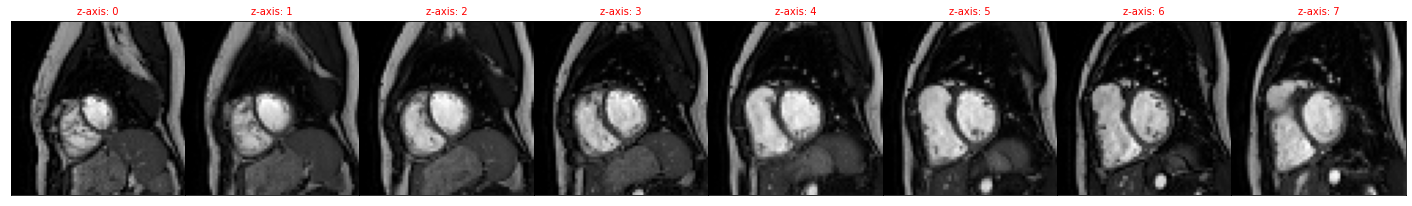

(5, 8, 64, 64, 1)


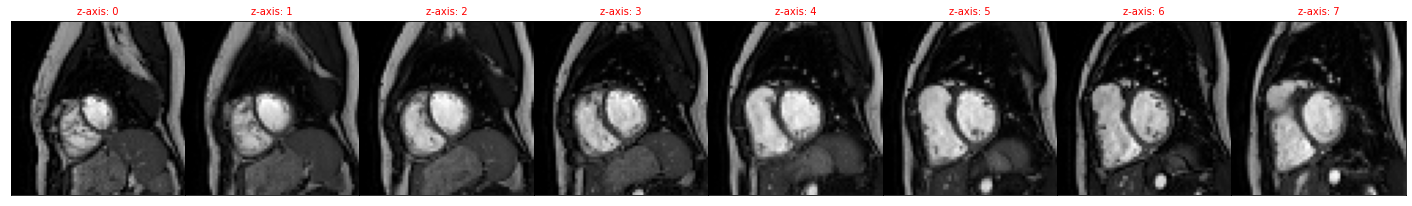

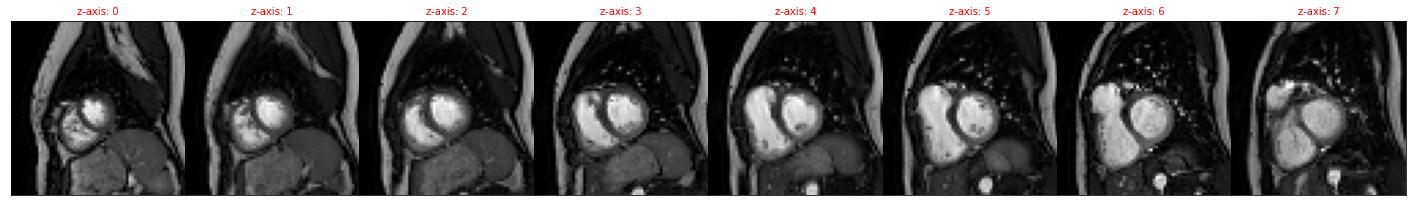

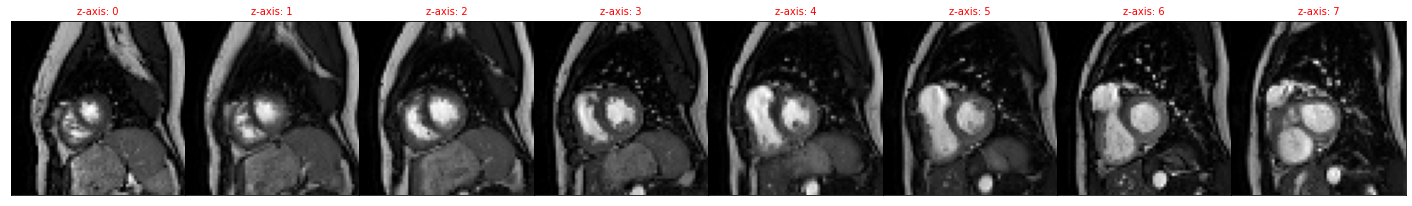

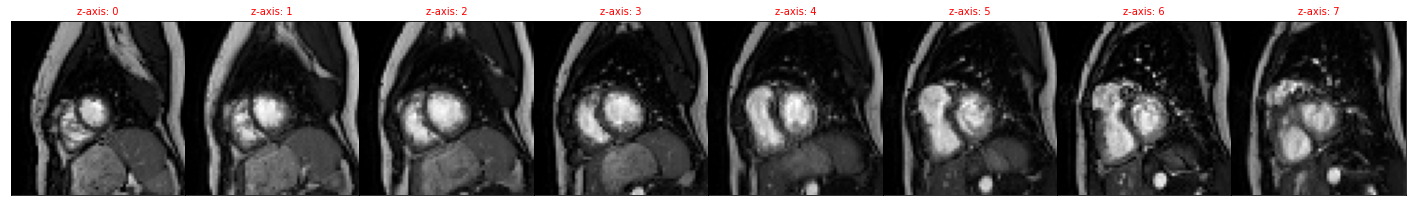

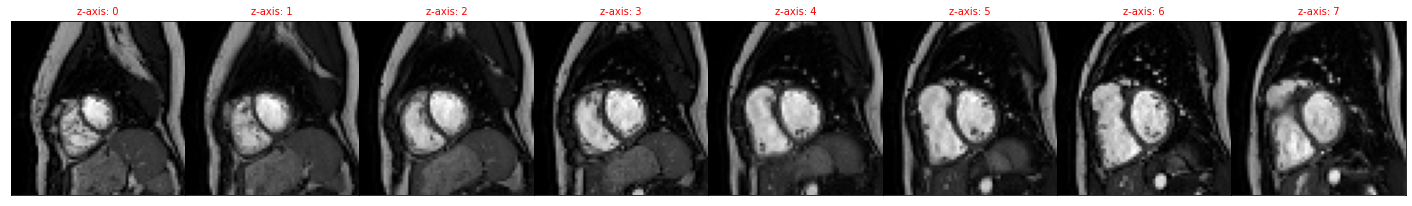

In [50]:
# slice of one patient
temp_in = inputs[0]
print('one patient input: {}'.format(temp_in.shape))
temp_idx = tf.cast(idxs[0], dtype = tf.int32)
print('one patient idx: {}'.format(temp_idx.shape))

# manually slice one timetep, as visual comparison
t1 = temp_idx[0]
print('t1: {}'.format(t1))
t1_in = temp_in[t1]
show_2D_or_3D(img=t1_in, interpol='bilinear',dpi=100,f_size=(5,5)); plt.show()

# slice ll 5 timeteps
t_all_in = tf.gather(temp_in, temp_idx)
print(t_all_in.shape)
_ = list(map(lambda x : show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), t_all_in ))

In [27]:
tf.squeeze(temp_idx)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 3,  8, 13, 16, 23])>

In [10]:
# get the true idx
temp = 
gt_idx = tf.math.argmax(outputs, axis=1).numpy()
print(gt_idx)
gt_max = gt_idx.max(axis=1).astype(int)
print(gt_max)

[[[1 1 1 1 1]
  [1 1 1 1 1]
  [0 1 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 1 1 1 0]
  [0 1 1 1 0]
  [0 1 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 1 1 1 1]
  [1 0 1 1 1]
  [1 0 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 ...

 [[1 1 1 1 0]
  [0 1 1 1 1]
  [0 1 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 1 1 0 1]
  [1 1 1 0 0]
  [0 1 1 1 0]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 0 1 1 1]
  [1 0 1 1 1]
  [1 0 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


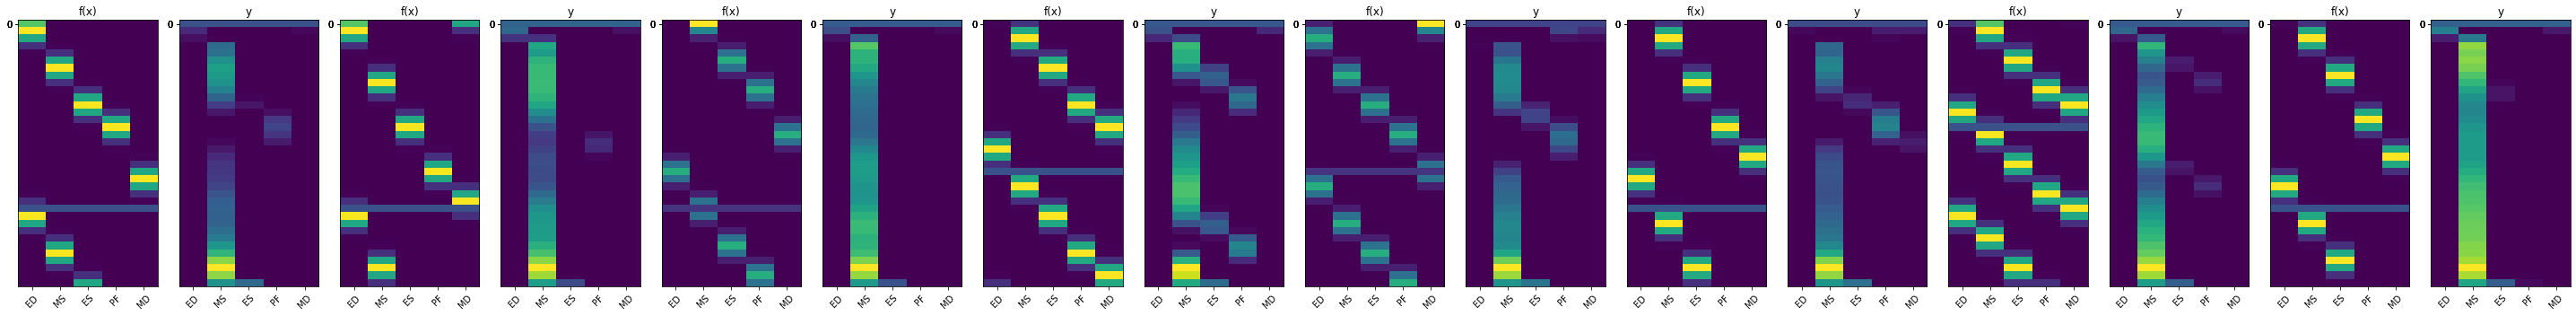

In [23]:
from src.visualization.Visualize import show_phases, show_phases_transpose
_ = show_phases(pred,outputs)

In [25]:
pred.shape

TensorShape([8, 2, 36, 5])

In [14]:
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
score_fn(outputs, pred).numpy()

24.776663

In [14]:
temp = outputs[:,0,...]
print(temp.shape)
print(temp.T.shape)
plt.imshow(temp.T[0])

NameError: name 'outputs' is not defined

In [15]:
# calculate the meandiff score for all batches
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
scores = []
for batch in validation_generator:
    x,y = batch
    p = model(x)
    scores.append(score_fn(y,p))
scores

ModuleNotFoundError: No module named 'src.utils.Metrics'

In [18]:
tf.reduce_mean(scores).numpy()

6.75

# Generator tests

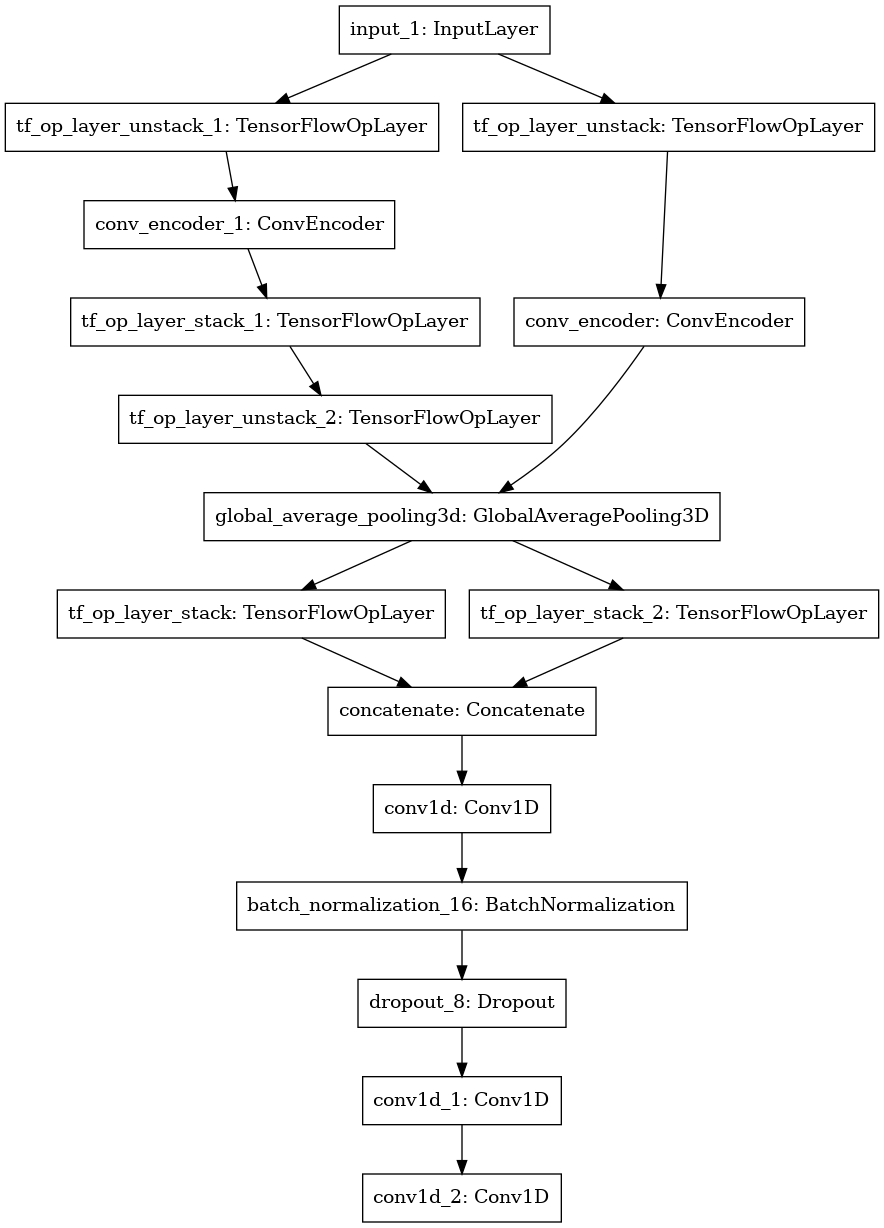

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [19]:
score_fn = meandiff_
score_fn(outputs, pred).numpy()

1.75

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)